# Solving an ODE with NN

## 1. From ODE to NN loss function
- Consider the 1st order IVP:

$ \frac{d x}{d t} = f( t , x ), $

$ t \in [ 0 , 1 ], $

$ x( 0 ) = x_0. $

- The initial value can be satisfied automatically by updating:

$ \hat{x}(t;\theta) = x_0 + t N(t;\theta). $

- The idea is to find the "residual" of the ODE (error between LHS/RHS) and integrate it squarred (to maintain positivity and only one 0 solution):

$ \large L(\theta) = \int_0^1 \left[ \frac{d \hat{x}(t;\theta)}{d t} - f( t , \hat{x}(t;\theta) ) \right]^2 dt. $

More generally, the same strategy can be applied to a higher order (even non-linear) ODE where more differentiations must be taken.

## 2. Solving the 1st order problem with stochastic gradient descent

- The algorithm converges (Robbins-Monro, 1951):

$ \large \theta_{i+1} = \theta_i - \frac{a_i}{N} \sum_{j=1}^{N} \nabla_{\theta} \left[ \frac{d \hat{x}(t_j;\theta_i)}{d t} - f( t , \hat{x}(t_j;\theta_i) ) \right]^2 $,

where $t_j$ are uniformly sampled in the interval ($t \in [ 0 , 1 ]$ in this case) at each iteration $i$.

## 3. Testing it out in practice - First Order ODE

To check how this works, perhaps the most famous first order ODE will be used as an example: radioactive decay of the form

$ \frac{dx(t)}{dt} = - \lambda x(t) $,

which has the solution

$ x(t) = x_0 e^{-\lambda x} $

for some initial value $ x(0) = x_0 $.

In [2]:
# Import the relevant libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# I am running this on a MacBook with Intel so I can only use the CPU
# You can use torch.device( "mps" ) for M1 chip at later Macs
device = torch.device("cpu")

### a) Lagaris method

The first method is based on [Lagaris et al](https://arxiv.org/pdf/physics/9705023.pdf). Instead of using stochastic optimization, it uses a lot of points to estimate the loss integral. It then simply uses a gradient-based optimization.

In [36]:
# Define the neural network - this one is based on Lagaris et al. 1997
NN = nn.Sequential( nn.Linear( 1 , 50 ) , 
                    nn.Sigmoid( ) , 
                    nn.Linear( 50 , 1 , bias = False ) )

# Initial condition
x_0 = 1.0

# Lambda constant (decay parameter)
lam_val = 1.0

# The \hat{x} function 
x_hat = lambda t: x_0 + t*NN( t )

# A RHS function can be added - it will be 0 in this case
f_rhs = lambda t, x: 0.0*t

# Defining the loss function
def loss( t ):
    t.requires_grad = True # Ensuring that gradients will be computed by t
    x_res_t = x_hat( t ) # Evaluate the \hat{x} function to obtain value for the input t
    # Find the derivative of x_hat with respect to t (x_hat_t)
    x_hat_t = torch.autograd.grad( x_res_t , t , grad_outputs = torch.ones_like( x_res_t ) ,
                                  create_graph = True )[ 0 ]
    return torch.mean( ( x_hat_t + lam_val*x_res_t - f_rhs( t , x_res_t ) )**2.0 )

In [37]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS( NN.parameters( ) )

# Defining a set of equally spaced points for evaluating the integral
t = torch.Tensor( np.linspace( 0.0 , 1.0 , 10 )[ : , None ] )

# Running the optimizer
def closure( ):
    optimizer.zero_grad( )
    l = loss( t )
    l.backward( )
    return l

# Running for 10 iterations
i_run = 10
for i in range( i_run ):
    optimizer.step( closure )

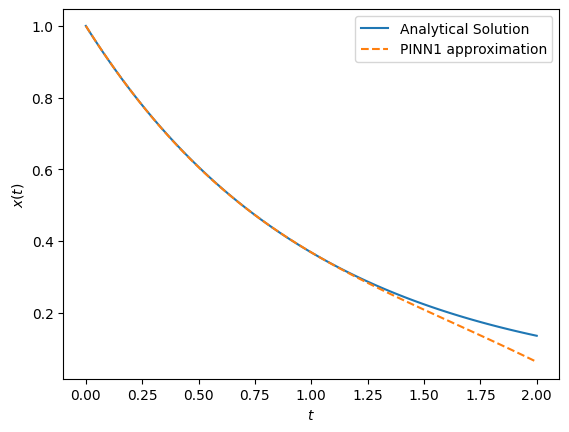

In [39]:
# Comparing with analytical solution outside of the trained range
t_arr = np.linspace( 0.0 , 2.0 , 100 )[ : , None ]
with torch.no_grad( ):
    x_arr_1 = x_hat( torch.Tensor( t_arr ) ).numpy( )
x_real = x_0*np.exp( - t_arr*lam_val )

fig, ax = plt.subplots( )
ax.plot( t_arr , x_real , label = "Analytical Solution" )
ax.plot( t_arr , x_arr_1 , '--', label = "PINN1 approximation" )
ax.set_xlabel( r"$t$" )
ax.set_ylabel( r"$x(t)$" )
plt.legend( loc = "best");

### b) Using stochastic gradient descent for the minimization

In [40]:
# Reinitializing the network for the new training
NN = nn.Sequential( nn.Linear( 1 , 50 ) , 
                    nn.Sigmoid( ) , 
                    nn.Linear( 50 , 1 , bias = False ) )

# We'll use the Adam optimizer to train on the random points
# Setting up a small learning rate (can be modified)
adam = torch.optim.Adam( NN.parameters( ) , lr = 0.01 )

# Batch size - random points per iteration of training
n_batch = 50

# The maximum number of iterations for the training
max_it = 1000

for i in range( max_it ):
    # Pick n_batch random points in the t range
    x = torch.rand( n_batch , 1 )
    # Zero-out the gradient buffers
    adam.zero_grad( )
    # Evaluate the loss
    l = loss( t )
    # Calculate the gradients
    l.backward( )
    # Update the network
    adam.step( )
    # Print the iteration number
    if i % 100 == 99:
        print( i + 1 )

100
200
300
400
500
600
700
800
900
1000


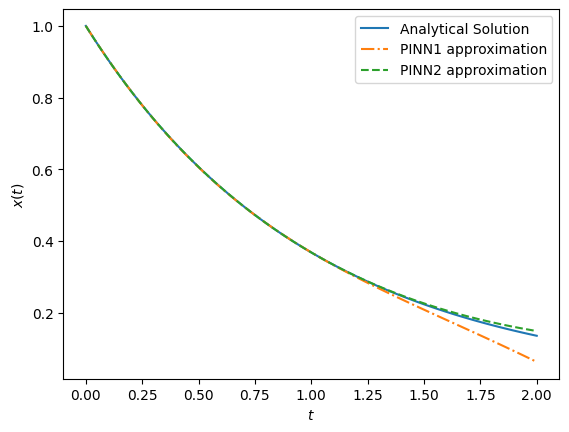

In [42]:
# Comparing with analytical solution outside of the trained range
t_arr = np.linspace( 0.0 , 2.0 , 100 )[ : , None ]
with torch.no_grad( ):
    x_arr_2 = x_hat( torch.Tensor( t_arr ) ).numpy( )
x_real = x_0*np.exp( - t_arr*lam_val )

fig, ax = plt.subplots( )
ax.plot( t_arr , x_real , label = "Analytical Solution" )
ax.plot( t_arr , x_arr_1 , '-.', label = "PINN1 approximation" )
ax.plot( t_arr , x_arr_2 , '--', label = "PINN2 approximation" )
ax.set_xlabel( r"$t$" )
ax.set_ylabel( r"$x(t)$" )
plt.legend( loc = "best");